# Model to predict the demand for shared bikes

In this notebook, we'll build a regression model to predict the `demand` of shared bikes using appropriate predictor variables.

#### Problem Statement:

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

Essentially, the company wants —

Which variables are significant in predicting the demand for shared bikes.
How well those variables describe the bike demands

## Step 1: Reading and Understanding the Data

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# import NumPy and Pandas and read the rental dataset
import numpy as np
import pandas as pd

# Import `matplotlib` and `seaborn` to visualise the data
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Read the dataset
days = pd.read_csv("day.csv")

In [3]:
# Check the head of the dataset
days.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
# Let's drop the fields that aren't useful for the analysis

#Registered and Casual should be dropped as the analysis needs to be done on cnt
days.drop('registered', axis=1, inplace=True)
days.drop('casual', axis=1, inplace=True)

#As Instant is the row index/id, no analysis can be done on it
days.drop('instant', axis=1, inplace=True)

#As we already have month, season, weekday etc in our dataset, we don't need the date
days.drop('dteday', axis=1, inplace=True)


Inspect the various aspects of the days dataframe

In [5]:
# Check the shape of the dataset day
days.shape

(730, 12)

In [6]:
# Let's check for null values in all the columns
days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


All the columns have values for all the rows.

In [7]:
#Let's summarise the columns with the numerical values in the dataset
days.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


There's no meaning of the summary for categorical columns, such as season, season, mnth, weekday, weathersit.
Although, mean of a couple of columns like workingday indicates that there may be rentals on working day as compared to holidays.

As cnt variable has higher numerical values as compared to other numerical variables, we'll have to apply scaling later on.

## Step 2: Visualising the Data

The aim is to identify
1. Multicollinerity
2. Association between predictors and the outcome variable

#### Visualising Numeric Variables

Let's make a pairplot of all the numeric variables

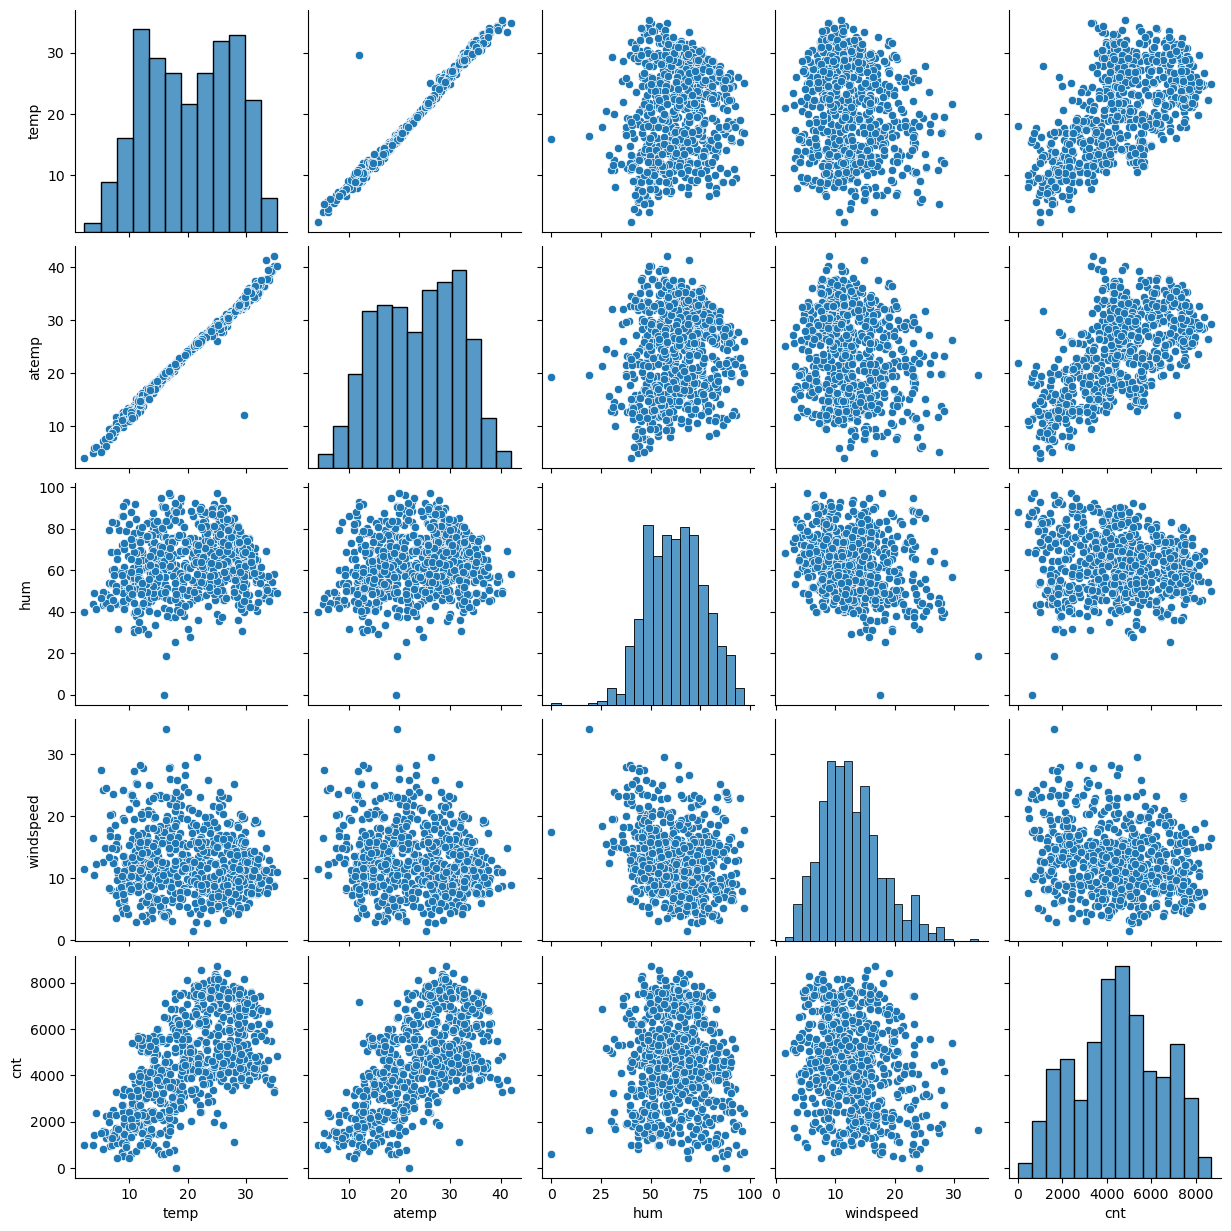

In [9]:
# But before that, let's create a new dataset from days without categorical fields 

cat_fields = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
days_wo_catfields = days.drop(columns=cat_fields)


sns.pairplot(days_wo_catfields)
plt.show()

#### Visualising Categorical Variables

Tthere are a few categorical variables as well. Let's make a boxplot for some of these variables.

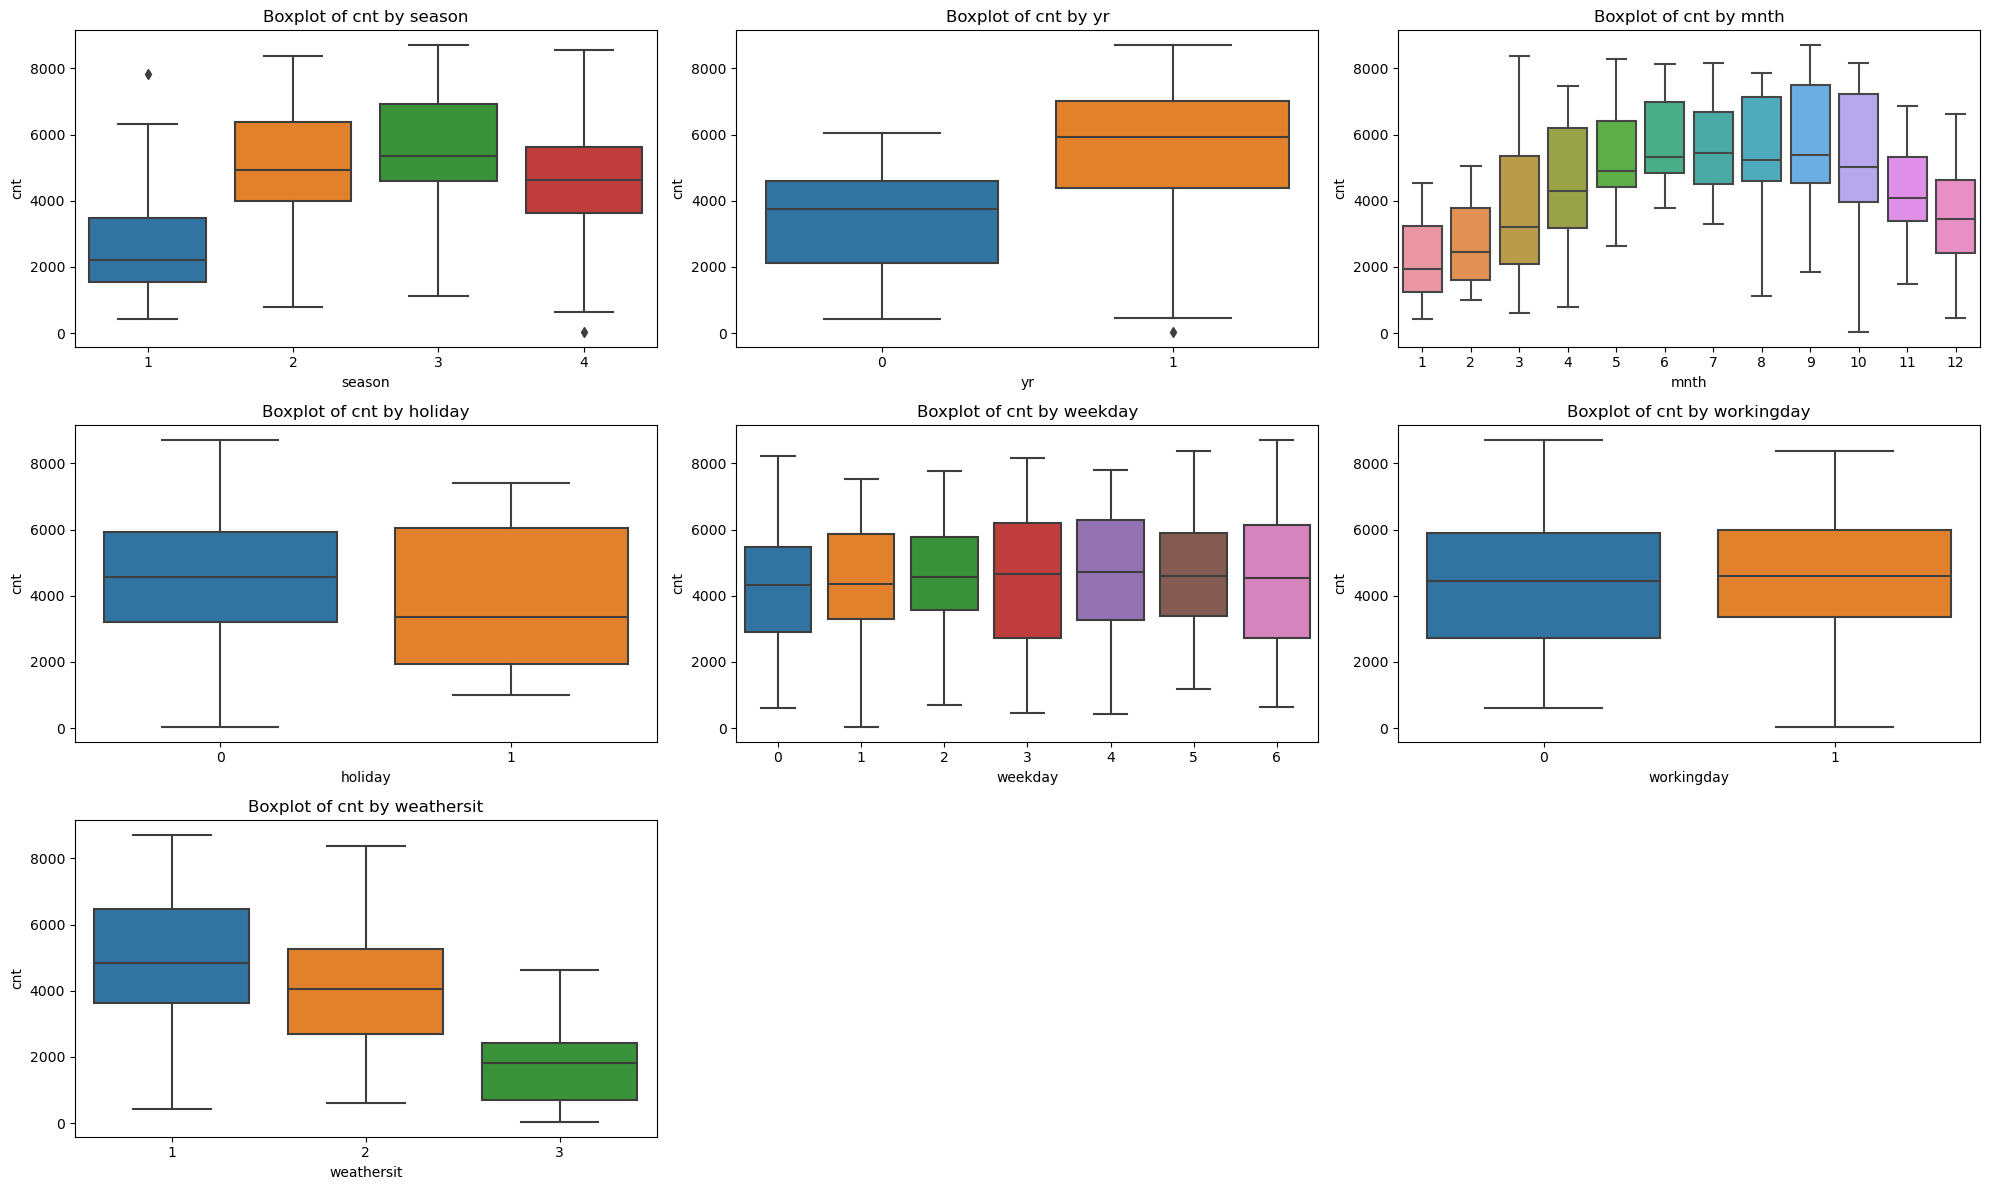

In [10]:
# Define the number of rows and columns for the subplot grid
rows = 3
cols = 3

plt.figure(figsize=(20, 12))  # Adjust the overall figure size

i = 1
for field in cat_fields:
    plt.subplot(rows, cols, i)
    sns.boxplot(x=field, y='cnt', data=days)
    plt.title(f'Boxplot of cnt by {field}')
    plt.xlabel(field)
    plt.ylabel('cnt')
    i += 1

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

Let's visualise some of these categorical features parallely by using the `hue` argument. 

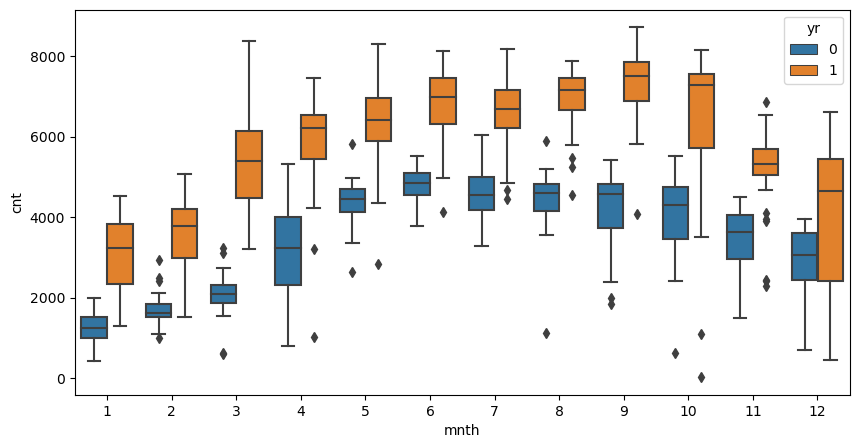

In [11]:
#Below is the plot for `mnth` with `yr` as the hue.
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'mnth', y = 'cnt', hue = 'yr', data = days)
plt.show()

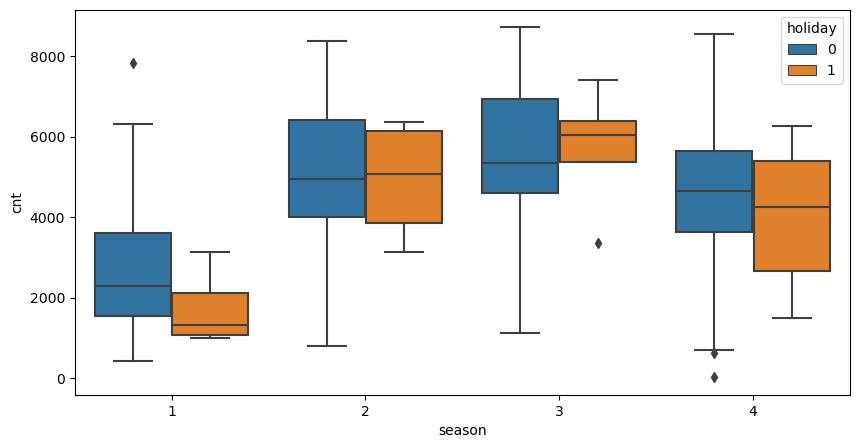

In [12]:
#Below is the plot for `season` with `holiday` as the hue.
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'season', y = 'cnt', hue = 'holiday', data = days)
plt.show()

In [13]:
#Above plots indicate that Season and month represents the same data.. 

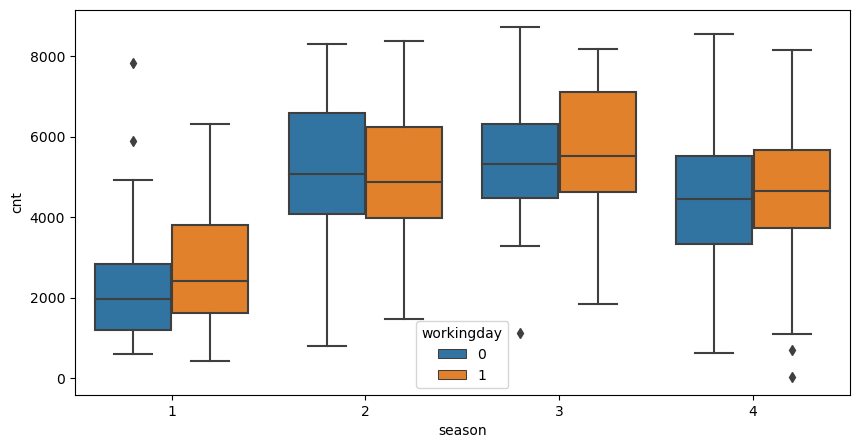

In [14]:
#Below is the plot for `season` with `workingday` as the hue.
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'season', y = 'cnt', hue = 'workingday', data = days)
plt.show()

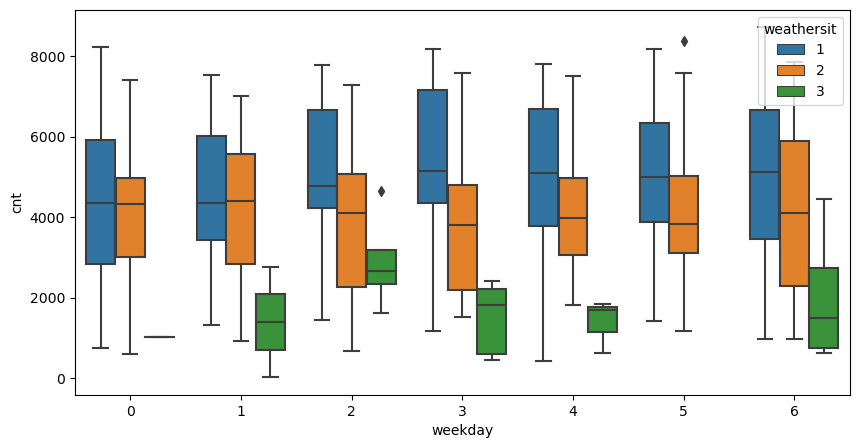

In [15]:
#Below is the plot for `weekday` with `weathersit` as the hue.
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'weekday', y = 'cnt', hue = 'weathersit', data = days)
plt.show()

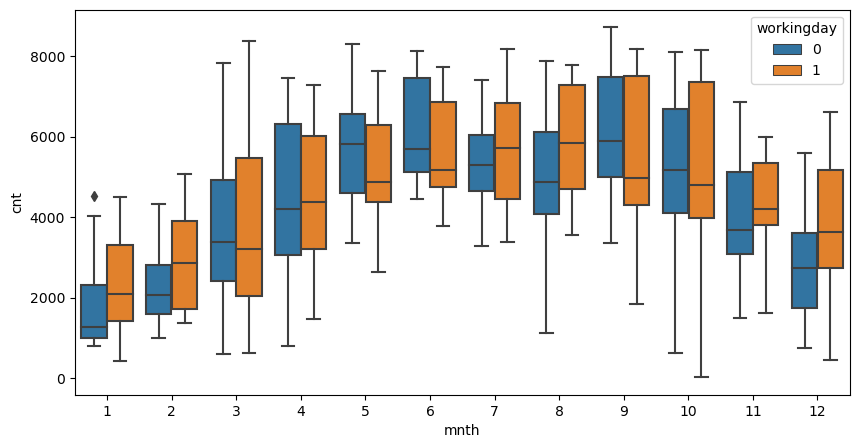

In [16]:
#Below is the plot for `mnth` with `workingday` as the hue.
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'mnth', y = 'cnt', hue = 'workingday', data = days)
plt.show()

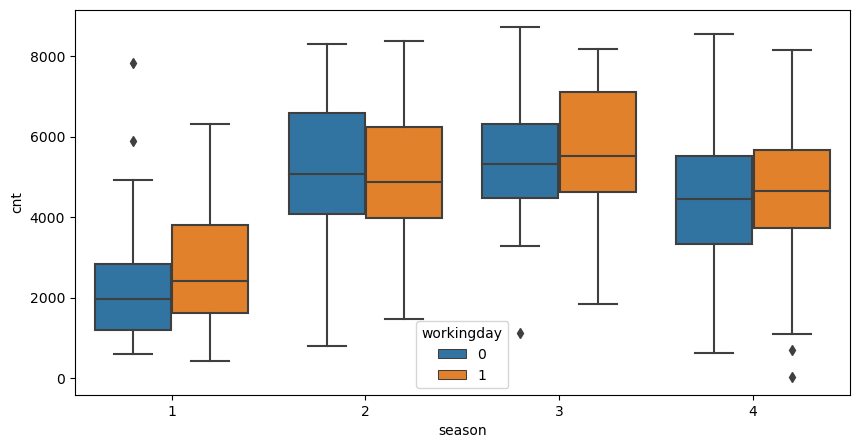

In [17]:
#Below is the plot for `season` with `workingday` as the hue.
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'season', y = 'cnt', hue = 'workingday', data = days)
plt.show()

## Step 3: Data Preparation

In [18]:
days.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


- There are no columns with strings. Let's go and create dummy variables 

### Dummy Variables

The variables `season`, `mnth`,`weekday`,`weathersit` has multiple levels. Let's create `dummy variables` for them.

In [19]:
print(days['season'].unique())

[1 2 3 4]


In [20]:
season_dummy = pd.get_dummies(days['season'], prefix='season', drop_first = True)
days = pd.concat([days, season_dummy], axis = 1)

In [21]:
mnth_dummy = pd.get_dummies(days['mnth'], prefix='mnth', drop_first = True)
days = pd.concat([days, mnth_dummy], axis = 1)

In [22]:
weekday_dummy = pd.get_dummies(days['weekday'], prefix='weekday', drop_first = True)
days = pd.concat([days, weekday_dummy], axis = 1)

In [23]:
weathersit_dummy = pd.get_dummies(days['weathersit'], prefix='weathersit', drop_first = True)
days = pd.concat([days, weathersit_dummy], axis = 1)

In [24]:
season_2_records = days[days['mnth'] == 4]
season_2_records.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
90,2,0,4,0,5,1,2,12.300000,14.17270,68.6250,...,0,0,0,0,0,0,1,0,1,0
91,2,0,4,0,6,0,2,12.915000,15.78185,65.3750,...,0,0,0,0,0,0,0,1,1,0
92,2,0,4,0,0,0,1,15.511653,18.93835,48.0000,...,0,0,0,0,0,0,0,0,0,0
93,2,0,4,0,1,1,1,23.506653,27.14645,42.6250,...,0,0,1,0,0,0,0,0,0,0
94,2,0,4,0,2,1,2,16.980847,19.91750,64.2083,...,0,0,0,1,0,0,0,0,1,0


In [25]:
# Drop the fields for which we have created the dummies

days.drop('season', axis=1, inplace=True)
days.drop('mnth', axis=1, inplace=True)
days.drop('weekday', axis=1, inplace=True)
days.drop('weathersit', axis=1, inplace=True)

## Step 4: Splitting the Data into Training and Testing Sets

Let's do the train-test split as it's the first step for performing regression 

In [26]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(days, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features 

As the column `cnt` has higher numerical values when compared to other variables, it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. Let's apply MinMax scaling.

In [27]:
scaler = MinMaxScaler()

In [28]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
#Leaving out yr, holiday and working day columns as they are already between 0 and 1
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [29]:
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,...,0,0,0,1,0,0,0,0,0,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,1,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,0,0,...,0,0,0,0,0,0,0,1,1,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,0,0,...,0,1,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,1,0,...,0,0,0,0,0,0,0,1,1,0


In [30]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768,0.513620,0.245098,0.262745,...,0.086275,0.084314,0.150980,0.131373,0.158824,0.133333,0.127451,0.154902,0.343137,0.029412
std,0.500429,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797,0.224593,0.430568,0.440557,...,0.281045,0.278131,0.358381,0.338139,0.365870,0.340268,0.333805,0.362166,0.475223,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


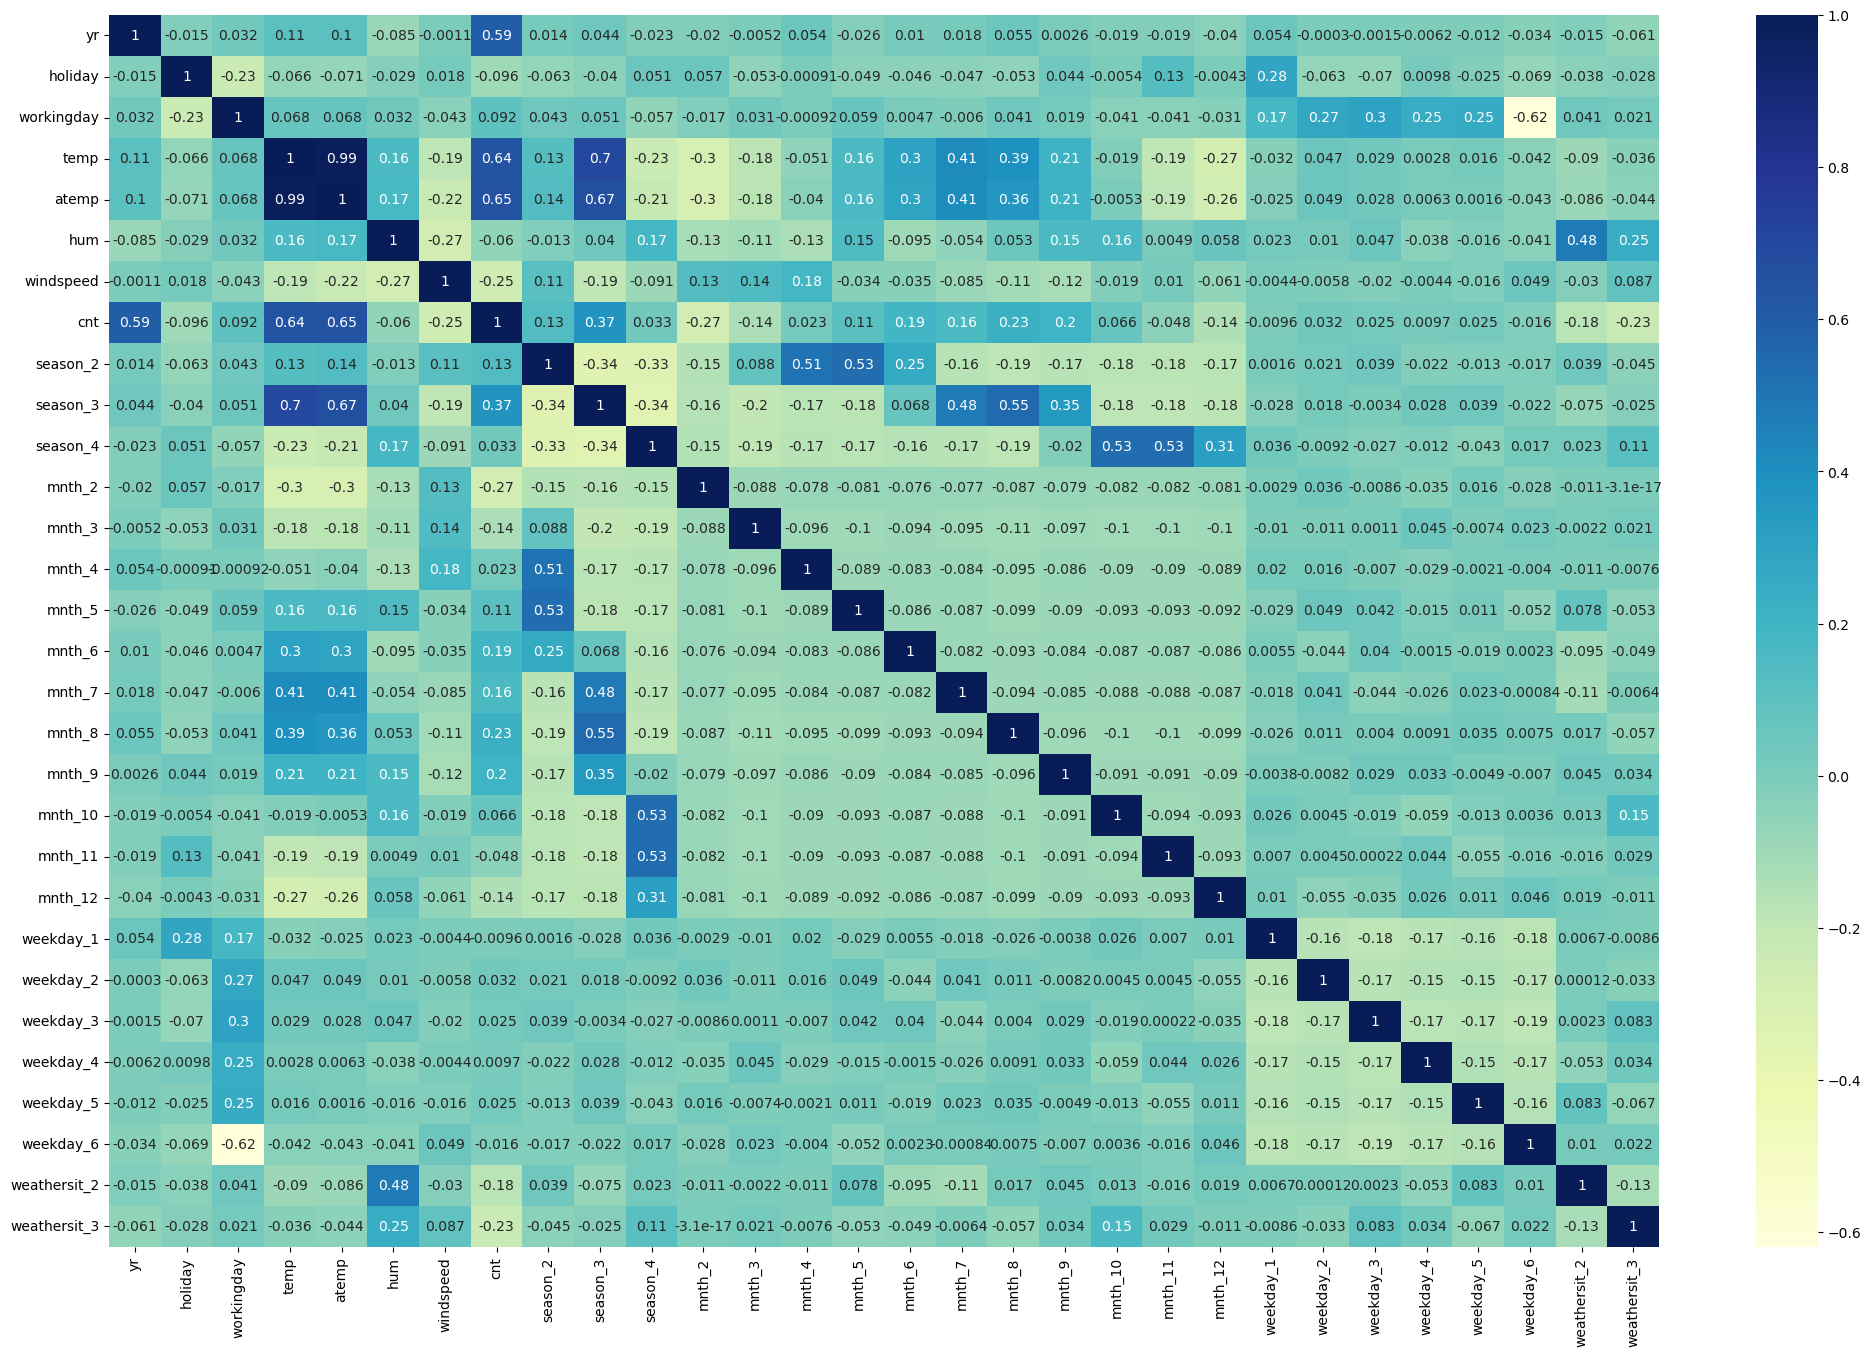

In [31]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (25, 16))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

We can see that `cnt` seems to be correlated to `temp` the most. There are other significant correlations of `cnt` with `yr`, `weathersit3`, `season3`, `month8` etc. 
Let's see a pairplot for `cnt` vs `temp`, `hum` and `windspeed`

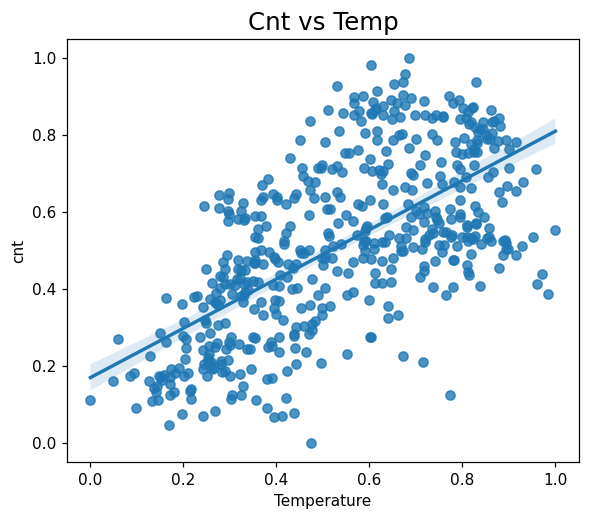

In [32]:
plt.figure(figsize=(6,5),dpi=110)
plt.title("Cnt vs Temp",fontsize=16)
sns.regplot(data = df_train,y="cnt",x="temp")
plt.xlabel("Temperature")
plt.show()

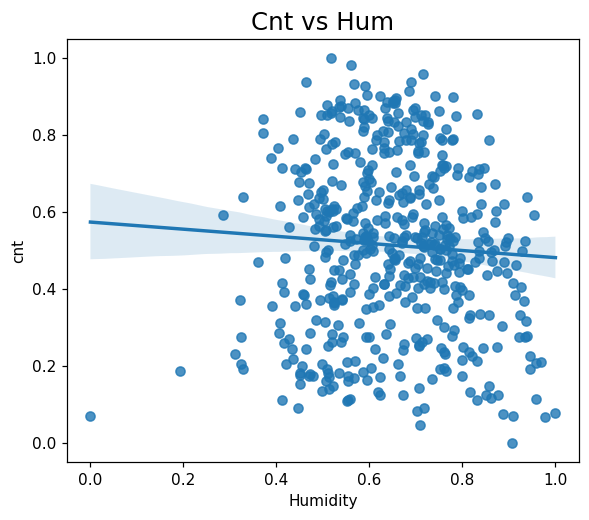

In [33]:
plt.figure(figsize=(6,5),dpi=110)
plt.title("Cnt vs Hum",fontsize=16)
sns.regplot(data = df_train,y="cnt",x="hum")
plt.xlabel("Humidity")
plt.show()

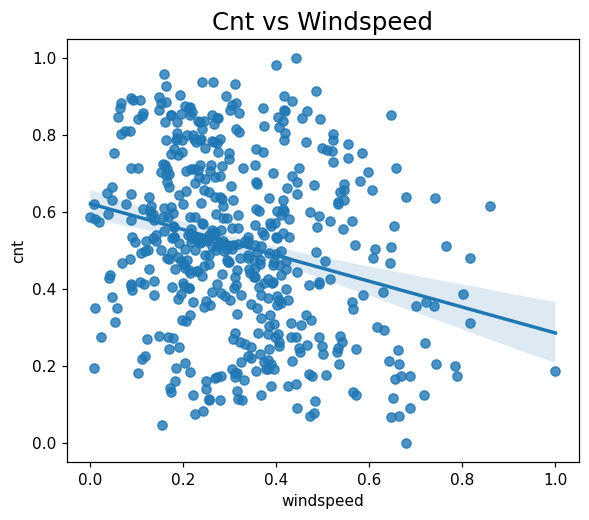

In [34]:
plt.figure(figsize=(6,5),dpi=110)
plt.title("Cnt vs Windspeed",fontsize=16)
sns.regplot(data = df_train,y="cnt",x="windspeed")
plt.show()

Observations from above plots:
     Temperature has a "structured" spread as copared to humidity and windspread
     Temp has positive and hum and windspeed have negativie correlation with cnt

### Dividing into X and Y sets for the model building

In [35]:
y_train = df_train.pop('cnt')
X_train = df_train

## Step 5: Building a linear model

Let's Fit a regression line through the training data using `statsmodels`. In `statsmodels`, we need to explicitly fit a constant using `sm.add_constant(X)` because if we don't perform this step, `statsmodels` fits a regression line passing through the origin, by default.

### Adding all the variables to the model

In [36]:
# Check all the columns of the dataframe

days.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_2', 'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weathersit_2', 'weathersit_3'],
      dtype='object')

In [37]:
# Recursive feature elimination 

lr = LinearRegression()
lr.fit(X_train, y_train)

rfe = RFE(estimator = lr, n_features_to_select = 15)
rfe = rfe.fit(X_train, y_train)

In [38]:
#List of variables selected in top 15 list

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_2', True, 1),
 ('season_3', True, 1),
 ('season_4', True, 1),
 ('mnth_2', False, 7),
 ('mnth_3', False, 2),
 ('mnth_4', False, 4),
 ('mnth_5', False, 3),
 ('mnth_6', False, 5),
 ('mnth_7', False, 8),
 ('mnth_8', True, 1),
 ('mnth_9', True, 1),
 ('mnth_10', True, 1),
 ('mnth_11', False, 9),
 ('mnth_12', False, 10),
 ('weekday_1', False, 11),
 ('weekday_2', False, 12),
 ('weekday_3', False, 14),
 ('weekday_4', False, 15),
 ('weekday_5', False, 13),
 ('weekday_6', True, 1),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1)]

In [39]:
# selecting the selected variable via RFE in col list

col = X_train.columns[rfe.support_]
print(col)

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'mnth_8', 'mnth_9', 'mnth_10', 'weekday_6',
       'weathersit_2', 'weathersit_3'],
      dtype='object')


In [40]:
# checking which columns has been rejected

X_train.columns[~rfe.support_]

Index(['atemp', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7',
       'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5'],
      dtype='object')

In [41]:
# Generic function to calculate VIF of variables
def calculateVIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif 

In [42]:
# dataframe with RFE selected variables

X_train_rfe = X_train[col]

In [43]:
# calculate VIF

calculateVIF(X_train_rfe)

,Features,VIF
3,temp,24.06
4,hum,17.47
7,season_3,8.19
2,workingday,5.05
5,windspeed,3.88
6,season_2,3.44
8,season_4,2.88
13,weathersit_2,2.15
0,yr,2.04
12,weekday_6,1.90


Temp has the highest VIF.. Let's check with p-values

In [44]:
# Let's build our first model
X_train_lm_1 = sm.add_constant(X_train_rfe)
lr_1 = sm.OLS(y_train,X_train_lm_1).fit()
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.7
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          1.89e-191
Time:                        21:46:16   Log-Likelihood:                 520.09
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     494   BIC:                            -940.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1950      0.029      6.791   

### Dropping the variable and updating the model

The summary and the VIF dataframe shows insignificant variables where VIF and p-value, both are high. Let's remove one of them, recalculate the model and repeat the process untill all insignificant features are removed from the model.

In [45]:
# As season_3 shows high VIF and p values hence we can drop it
X_train_new = X_train_rfe.drop(['season_3'], axis = 1)


# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
4,hum,16.59
3,temp,10.01
2,workingday,5.05
5,windspeed,3.82
7,season_4,2.27
12,weathersit_2,2.14
0,yr,2.03
11,weekday_6,1.90
6,season_2,1.83
10,mnth_10,1.62


Now, hum has the highest VIF.. let's build the LR model for the second time and check p values

In [46]:
# Building 2nd linear regression model

X_train_lm_2 = sm.add_constant(X_train_new)
lr_2 = sm.OLS(y_train,X_train_lm_2).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     197.5
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          3.24e-192
Time:                        21:46:18   Log-Likelihood:                 519.16
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     495   BIC:                            -944.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1945      0.029      6.770   

Now the p-value for all the features are in acceptable range, but the VIF is still high for hum and temp. 
Let's drop Hum as it the highest VIF while keeping an eye on the p-values and Adjusted R-Squared to see if the model improves

In [47]:
X_train_new = X_train_new.drop(['hum'], axis = 1)


# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
3,temp,6.38
2,workingday,4.39
4,windspeed,3.60
0,yr,2.02
6,season_4,2.02
5,season_2,1.82
10,weekday_6,1.77
9,mnth_10,1.62
7,mnth_8,1.59
11,weathersit_2,1.54


In [48]:
# Building 3rd linear regression model

X_train_lm_3 = sm.add_constant(X_train_new)
lr_3 = sm.OLS(y_train,X_train_lm_3).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     202.9
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          6.16e-189
Time:                        21:46:20   Log-Likelihood:                 508.57
No. Observations:                 510   AIC:                            -989.1
Df Residuals:                     496   BIC:                            -929.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0945      0.019      4.961   

Adjusted R-Squared still looks good. Let's try dropping holiday and see how the model behaves. 

In [49]:
X_train_new = X_train_new.drop(['holiday'], axis = 1)


# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,temp,6.26
1,workingday,4.07
3,windspeed,3.49
0,yr,2.02
5,season_4,1.99
4,season_2,1.82
9,weekday_6,1.70
8,mnth_10,1.61
6,mnth_8,1.59
10,weathersit_2,1.54


In [50]:
# Building 4th linear regression model

X_train_lm_4 = sm.add_constant(X_train_new)
lr_4 = sm.OLS(y_train,X_train_lm_4).fit()
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     218.2
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          2.86e-189
Time:                        21:46:21   Log-Likelihood:                 506.56
No. Observations:                 510   AIC:                            -987.1
Df Residuals:                     497   BIC:                            -932.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0856      0.019      4.610   

Let's build our final model and try dropping Temp. Although, we know that temp does impact bike rentals, but let's see what happens if we try dropping it

In [51]:
# Create a copy of X_train from model 4 before dropping temp, so that it can be used later
X_train_new_4_model = X_train_new

#Drop temp feature
X_train_new = X_train_new.drop(['temp'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
1,workingday,3.33
2,windspeed,3.25
4,season_4,1.98
0,yr,1.90
3,season_2,1.60
7,mnth_10,1.57
8,weekday_6,1.56
9,weathersit_2,1.54
5,mnth_8,1.23
6,mnth_9,1.15


VIF values looks amazing. Let's check the model now.. 

In [52]:
# Building 5th linear regression model

X_train_lm_5 = sm.add_constant(X_train_new)
lr_5 = sm.OLS(y_train,X_train_lm_5).fit()
print(lr_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     90.60
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          2.80e-111
Time:                        21:46:24   Log-Likelihood:                 318.77
No. Observations:                 510   AIC:                            -613.5
Df Residuals:                     498   BIC:                            -562.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3532      0.021     16.786   

The Adjusted R-Squared dropped significantly. Hence, we can't remove temp from our model. Hence, the 4th model has the best selection of features. Let's use that model to make the predictions

For model 4:
    F-Statistics value of 218.2 (which is greater than 1) and the p-value of 2.86e-189 i.e almost equals to zero, 
    states that the overall model is significant

## Step 6: Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [53]:
y_train_cnt = lr_4.predict(X_train_lm_4)

Text(0.5, 0, 'Errors')

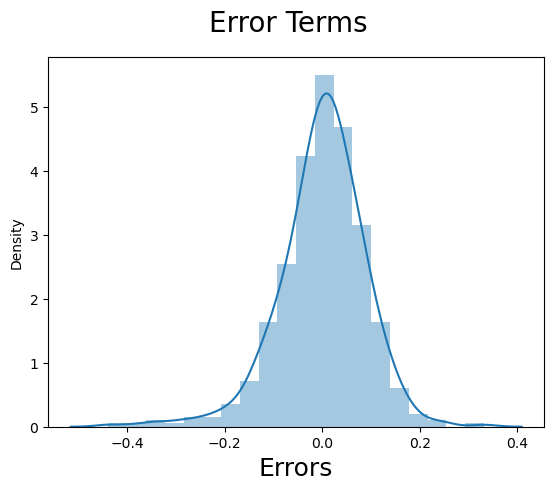

In [54]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

## Step 7: Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the best model, i.e. fourth model.

#### Applying the scaling on the test sets

In [55]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,1,...,0,0,1,0,0,0,0,0,1,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,1,0,...,0,0,0,0,1,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,0,0,0,0,0,1,0,0,1,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,1,...,0,0,0,0,1,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,1,0,...,0,0,0,0,0,1,0,0,0,0


#### Dividing into X_test and y_test

In [56]:
y_test = df_test.pop('cnt')
X_test = df_test

In [57]:
col1 = X_train_new_4_model.columns

X_test = X_test[col1]

# Adding constant variable to test dataframe
X_test_lm_4 = sm.add_constant(X_test)

In [58]:
y_pred = lr_4.predict(X_test_lm_4)

In [59]:
r2 = r2_score(y_test, y_pred)
round(r2,4)

0.8024

For model 4, the R Squered and the Adjusted R Squered values where 0.84 and 0.837 which is quite close to the R Squered for the test set. Hence, we can conclude that our model could predict on the test data with good accuracy.

## Step 8: Model Evaluation

Let's now plot the graph for actual versus predicted values.

Text(0, 0.5, 'y_pred')

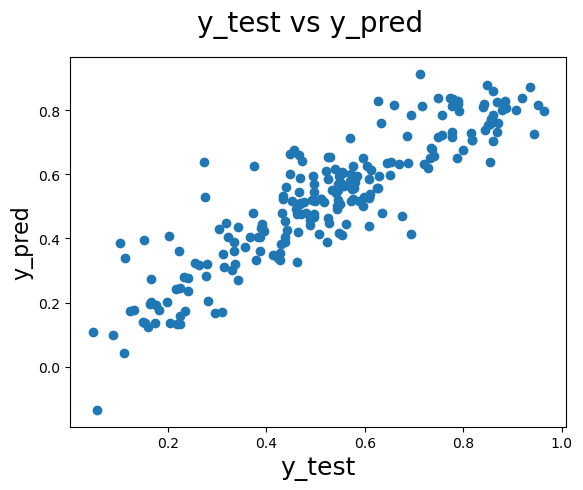

In [60]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

In [61]:
round(lr_4.params,4)

const           0.0856
yr              0.2331
workingday      0.0555
temp            0.5116
windspeed      -0.1542
season_2        0.1015
season_4        0.1260
mnth_8          0.0546
mnth_9          0.1172
mnth_10         0.0384
weekday_6       0.0662
weathersit_2   -0.0849
weathersit_3   -0.2932
dtype: float64


We can see that the equation of our best fitted line is:

cnt = 0.0856 + 0.2331 x yr + 0.0555 x workingday + 0.5116 x temp - 0.1542 x windspeed + 0.1015 x season_2 + 0.1260 x season_4 + 0.0546 x mnth_8 + 0.1172 x mnth_9 + 0.0384 x mnth_10 + 0.0662 x weekday_6 - 0.0849 x weathersit_2 - 0.2932 x weathersit_3
